In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
normalization = 255

In [3]:
def plot_J(J_history):
    x = np.arange(0, len(J_history))
    plt.plot(x, J_history)
    plt.show()

In [4]:
def normalize(X):
    return X / normalization

In [5]:
def denormalize(X):
    return X * normalization

In [244]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from mpmath import *
from sympy import *

In [6]:
class LogisticRegression():
    def __init__(self, normalize=True):
        self.normalize = normalize
        self.__mean = None
        self.__std = None
    
    def get_mean(self):
        return self.__mean
    
    def get_std(self):
        return self.__std
    
    def fit(self, X_vert, Y_vert, alpha, num_iters, epsilon):
        # X transformations
        if self.normalize == True:
            self.X_ = self.__normalize(X_vert)
        else:
            self.X_ = X_vert
        self.X_ = self.X_.T
 
        # Y transformations
        self.Y_ = Y_vert.T

        self.W = np.full(( self.X_.shape[0],self.Y_.shape[0]),0.01)
        self.b = 0.0
        self.W, self.b, self.Js = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, alpha, num_iters, epsilon)

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)

        if self.normalize:
            X_norm = (X - self.__mean) / self.__std
            z = self.__stable_softmax(np.dot(self.W.T,X_norm.T)+self.b)
        else:
            z = self.__stable_softmax(np.dot(self.W.T,X.T)+self.b)
    
        y_pred = np.zeros(z.shape[1], dtype=int)
        for i in range(z.shape[1]):
            y_pred[i] = np.argmax(z[:, i])    
        
        return y_pred

    def predict_by_labels(self, X, y_labels):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        
        if self.normalize:
            X_norm = (X - self.__mean) / self.__std
            z = self.__stable_softmax(np.dot(self.W.T,X_norm.T)+self.b)
        else:
            z = self.__stable_softmax(np.dot(self.W.T,X.T)+self.b)
            
        y_pred = np.full((z.shape[1]), {})
        for i in range(z.shape[1]):
            y_pred[i] = { y_labels[j]: z[j][i] for j in range(z.shape[0])}
        return y_pred
            
    def get_cost_history(self):
        check_is_fitted(self)
        return self.Js

    def __normalize(self, X):
        if self.__mean is None and self.__std is None:
            mean = np.zeros([X.shape[1]])
            std  = np.ones([X.shape[1]])
            
            for i in range(X.shape[1]):
                if (np.std(X.iloc[:, i]) != 0):
                    mean[i] = np.mean(X.iloc[:, i])
                    std[i] = np.std(X.iloc[:, i])
            
            self.__mean = mean
            self.__std = std

        X_new = (X - self.__mean) / self.__std
        return X_new

    def __cost_function(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None
        
        J = (1 / m) * np.sum(-Y * np.log(A) - (1 - Y) * np.log(1 - A))
        return J

    def __cross_entropy(self, X, Y, A):
        m = X.shape[0]
        if m == 0:
            return None
        
        J = (-1 / m) * np.sum(Y.T * np.log(A.T))
        return J
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __softmax(self, z):
        exps = np.exp(z)
        return exps / exps.sum(axis=0, keepdims=True)

    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)

    def __forward_backward_propagation(self, X, Y, W, b):        
        # forward propagation
        m = X.shape[1]

        z = np.dot(W.T,X) + b
        A = self.__stable_softmax(z)
        cost = self.__cross_entropy(X, Y, A)

        # backward propagation
        dz = A - Y
        derivative_weights = (1 / m) * np.dot(X, dz.T)
        derivative_bias = (1 / m) * np.sum(dz)

        return cost, derivative_weights, derivative_bias

    def __gradient_descent(self, X, Y, W, b, alpha, num_iters, epsilon):        
        # num of samples
        m = X.shape[0]
        # num of features
        n = X.shape[1]

        J_history = []

        for i in range(num_iters):
            J, delta_weights, delta_bias = self.__forward_backward_propagation(X, Y, W, b)

            W = W - alpha * delta_weights
            b = b - alpha * delta_bias

            if i % 100 == 0:
                print(f"{i} iteration: {J}")

            J_history.append(J)

        return W, b, J_history

In [150]:
class AttackNoise():
    # Targeted Fast Gradient Sign Method Attack
    def attack(self, X_vert, Y_vert_true, predict_func, max_perturbation=1, values_range=(0, 255)):
        self.X_ = X_vert.T
        self.Y_ = np.expand_dims(Y_vert_true, axis=1)
        
        self.perturbation = max_perturbation
        self.values_range = values_range

        self.X_ = self.__add_noise(self.X_, self.Y_, predict_func)                
        return self.X_
   
    def __generate_noise(self, m, n):
        return np.random.uniform(low=-1, high=1, size=(m, n)) * self.perturbation

    def __is_tricked(self, X, Y, predict_func):
        # true class position
        true_class = np.argmax(Y[:, 0] != 0)

        if (predict_func(np.array(X))[0] == true_class):
            return False
        return True
    
    def __add_noise(self, X, Y, predict_func):
        # num of features
        m = X.shape[0]
        # num of samples
        n = X.shape[1]

        noise = self.__generate_noise(m, n);
        
        X = X + noise

        X[X > 1] = 1
        X[X < 0] = 0
                        
        if self.__is_tricked(X.T, Y, predict_func) == True:
            self.tricked = True
        else:
            self.tricked = False
        
        X_vert = X.T
        return X_vert

In [239]:
class AttackTIFGSM():
    # Targeted Fast Gradient Sign Method Attack
    def attack(self, X_vert, W, b, Y_vert_goal, predict_func, max_perturbation=1, max_iters=10, stop_when_tricked=True):
        self.num_iters = 0
        self.max_iters = max_iters
        self.stop_when_tricked = stop_when_tricked
        
        self.W = W
        self.b = b

        self.Y_ = np.expand_dims(Y_vert_goal, axis=1)
        self.X_ = X_vert.T
        
        self.X_ = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, max_perturbation, predict_func)                
        return self.X_
            
    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)
    
    def __forward_backward_propagation(self, X, Y, W, b):
        # forward propagation
        m = X.shape[1]
        z = np.dot(W.T,X) + b
        A = self.__stable_softmax(z)

        # backward propagation
        dz = A - Y
        derivative_x = (1 / m) * np.dot(W, dz)
        return derivative_x

    def __is_tricked(self, X, Y, predict_func):
        # goal class position
        goal_class = np.argmax(Y[:, 0] != 0)
        if (predict_func(np.array(X))[0] != goal_class):
            return False
        return True
    
    def __gradient_descent(self, X, Y, W, b, max_perturbation, predict_func):        
        # num of samples
        m = X.shape[0]
        # num of features
        n = X.shape[1]
        
        alpha = max_perturbation / self.max_iters
        
        for i in range(self.max_iters):
            delta_x = self.__forward_backward_propagation(X, Y, W, b)
            X = X - alpha * np.sign(delta_x)
            
            X[X > 1] = 1
            X[X < 0] = 0

            self.num_iters += 1
            
            if self.stop_when_tricked and self.__is_tricked(X.T, Y, predict_func) == True:
                break
                
        if self.__is_tricked(X.T, Y, predict_func) == True:
            self.tricked = True
        else:
            self.tricked = False
        
        self.perturbation = alpha * self.num_iters
        
        X_vert = X.T
        return X_vert

In [303]:
class AttackIFGSM():
    # Iterative Fast Gradient Sign Method Attack
    def attack(self, X_vert, W, b, Y_vert_true, predict_func, max_perturbation=1, max_iters=10, stop_when_tricked=True):
        self.num_iters = 0
        self.max_iters = max_iters
        self.stop_when_tricked = stop_when_tricked
        
        self.W = W
        self.b = b

        self.Y_ = np.expand_dims(Y_vert_true, axis=1)
        self.X_ = X_vert.T
        
        self.X_ = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, max_perturbation, predict_func)                
        return self.X_
    
    def __softmax(self, z):
        exps = np.exp(z)
        return exps / exps.sum(axis=0, keepdims=True)
   
    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)
        
    def __softmax_bigfloat(self, z):
        z = np.array(z, dtype=Float)
        exps = Float(np.e) ** z
        return exps / exps.sum(axis=0, keepdims=True)
    
    def __forward_backward_propagation(self, X, Y, W, b):
        # forward propagation
        m = X.shape[1]
        z = np.dot(W.T,X) + b
        A = self.__stable_softmax(z)
        
        # backward propagation
        dz = A - Y
        derivative_x = (1 / m) * np.dot(W, dz)
        return np.array(derivative_x, dtype=float)

    def __is_tricked(self, X, Y, predict_func):
        # goal class position
        true_class = np.argmax(Y[:, 0] != 0)
        if (predict_func(np.array(X))[0] == true_class):
            return False
        return True

    def __gradient_descent(self, X, Y, W, b, max_perturbation, predict_func):        
        # num of samples
        m = X.shape[0]
        # num of features
        n = X.shape[1]
        
        #while (not self.__is_tricked(X.T, Y, predict_func)) and (self.num_iters < self.max_iters):
        alpha = max_perturbation / self.max_iters
        
        for i in range(self.max_iters):
            delta_x = self.__forward_backward_propagation(X, Y, W, b)
            X = X + alpha * np.sign(delta_x)
            
            X[X > 1] = 1
            X[X < 0] = 0

            self.num_iters += 1
            
            if self.stop_when_tricked and self.__is_tricked(X.T, Y, predict_func) == True:
                break
                
        if self.__is_tricked(X.T, Y, predict_func) == True:
            self.tricked = True
        else:
            self.tricked = False
        
        self.perturbation = alpha * self.num_iters
        
        X_vert = X.T
        return X_vert

In [256]:
class AttackFGSM():
    # Iterative Fast Gradient Sign Method Attack
    def attack(self, X_vert, W, b, Y_vert_true, predict_func, max_perturbation=1):
        self.perturbation = max_perturbation
        
        self.W = W
        self.b = b

        self.Y_ = np.expand_dims(Y_vert_true, axis=1)
        self.X_ = X_vert.T
        
        self.X_ = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, predict_func)                
        return self.X_
    
    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)
        
    def __forward_backward_propagation(self, X, Y, W, b):
        # forward propagation
        m = X.shape[1]
        z = np.dot(W.T,X) + b
        A = self.__stable_softmax(z)
        
        # backward propagation
        dz = A - Y
        derivative_x = (1 / m) * np.dot(W, dz)
        return np.array(derivative_x, dtype=float)

    def __is_tricked(self, X, Y, predict_func):
        # goal class position
        true_class = np.argmax(Y[:, 0] != 0)
        if (predict_func(np.array(X))[0] == true_class):
            return False
        return True

    def __gradient_descent(self, X, Y, W, b, predict_func):        
        m = X.shape[0]
        n = X.shape[1]
        
        delta_x = self.__forward_backward_propagation(X, Y, W, b)
        X = X + self.perturbation * np.sign(delta_x)
            
        X[X > 1] = 1
        X[X < 0] = 0

        if self.__is_tricked(X.T, Y, predict_func) == True:
            self.tricked = True
        else:
            self.tricked = False
        
        X_vert = X.T
        return X_vert

In [ ]:
class AttackDeepFool():
    # Deep Fool Attack
    def attack(self, X_vert, W, b, Y_vert_true, predict_func, max_perturbation=1, max_iters=10, stop_when_tricked=True):
        self.num_iters = 0
        self.max_iters = max_iters
        self.stop_when_tricked = stop_when_tricked
        
        self.W = W
        self.b = b

        self.Y_ = np.expand_dims(Y_vert_true, axis=1)
        self.X_ = X_vert.T
        
        self.X_ = self.__gradient_descent(self.X_, self.Y_, self.W, self.b, max_perturbation, predict_func)                
        return self.X_
    
    def __softmax(self, z):
        exps = np.exp(z)
        return exps / exps.sum(axis=0, keepdims=True)
   
    def __stable_softmax(self, z):
        exps = np.exp(z - np.max(z))
        return exps / exps.sum(axis=0, keepdims=True)
        
    def __softmax_bigfloat(self, z):
        z = np.array(z, dtype=Float)
        exps = Float(np.e) ** z
        return exps / exps.sum(axis=0, keepdims=True)
    
    def __forward_backward_propagation(self, X, Y, W, b):
        # forward propagation
        m = X.shape[1]
        z = np.dot(W.T,X) + b
        A = self.__stable_softmax(z)
        
        # backward propagation
        dz = A - Y
        derivative_x = (1 / m) * np.dot(W, dz)
        return np.array(derivative_x, dtype=float)

    def __is_tricked(self, X, Y, predict_func):
        # goal class position
        true_class = np.argmax(Y[:, 0] != 0)
        if (predict_func(np.array(X))[0] == true_class):
            return False
        return True

    def __gradient_descent(self, X, Y, W, b, max_perturbation, predict_func):        
        # num of samples
        m = X.shape[0]
        # num of features
        n = X.shape[1]
        
        #while (not self.__is_tricked(X.T, Y, predict_func)) and (self.num_iters < self.max_iters):
        alpha = max_perturbation / self.max_iters
        
        for i in range(self.max_iters):
            delta_x = self.__forward_backward_propagation(X, Y, W, b)
            X = X + alpha * np.sign(delta_x)
            
            X[X > 1] = 1
            X[X < 0] = 0

            self.num_iters += 1
            
            if self.stop_when_tricked and self.__is_tricked(X.T, Y, predict_func) == True:
                break
                
        if self.__is_tricked(X.T, Y, predict_func) == True:
            self.tricked = True
        else:
            self.tricked = False
        
        self.perturbation = alpha * self.num_iters
        
        X_vert = X.T
        return X_vert

In [10]:
filename_test = "./digit-recognizer/test.csv"
filename_train = "./digit-recognizer/train.csv"

df_train = pd.read_csv(filename_train, delimiter=',')
df_test = pd.read_csv(filename_test, delimiter=',')

X = df_train.loc[:, df_train.columns != "label"]
y = df_train.loc[:, df_train.columns == "label"]
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(42000, 784), y=(42000, 1)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600, 1)
Test set: X=(8400, 784), y=(8400, 1)


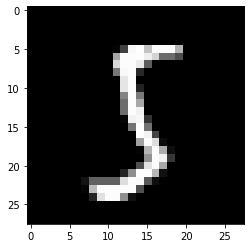

In [12]:
X_t =  X_train.values.reshape(-1,28,28,1)
g = plt.imshow(X_t[0][:, :, 0], 'gray')

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train)

Y_train = encoder.transform(y_train).toarray()
y_labels = [x[3:] for x in  encoder.get_feature_names()]

# encoder.fit(y_test)
# Y_test = encoder.transform(y_test).toarray()

0 iteration: 98.68221827117338
100 iteration: 16.668592739788266
200 iteration: 14.682138948345427
300 iteration: 13.795254691797975
400 iteration: 13.258221106507815
500 iteration: 12.8853829558503
600 iteration: 12.605104820088682
700 iteration: 12.383068279446976
800 iteration: 12.200519693764313
900 iteration: 12.046245190715865


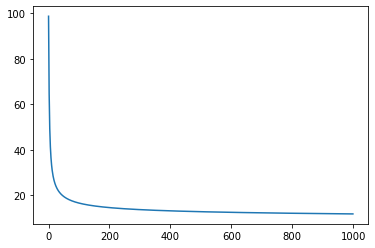

11.914323733433374
Wall time: 1min 39s


In [346]:
%%time
lg = LogisticRegression(normalize=False)
lg.fit(normalize(X_train), Y_train, 0.5, 1000, 1e-15)

plot_J(lg.get_cost_history())
print(lg.get_cost_history()[-1])

In [305]:
y_pred = lg.predict(normalize(X_test))
y_pred

array([0, 1, 1, ..., 3, 0, 0])

In [16]:
# n = len(y_labels)

In [17]:
# X_test_norm = (X_test - lg.get_mean()) / lg.get_std()

# num = 0
# den = 0
# iter_res_dict = {}
# y = np.zeros(n)



# for i in range(10):
#     x = np.expand_dims(X_test_norm.iloc[i, :], axis=0)
#     for j in range(len(y_labels)):
#         y = np.zeros(n)
#         y[j] = 1
#         for k in range(100):
#             iters, result  = get_trick_iteration(x, y_labels, k, 0.01, goal=y, model=lg)
#             #if (iters == 10):
#             #    print(i, y)
#             if iters in iter_res_dict.keys():
#                 iter_res_dict[iters]["appearance_count"] += 1 
#                 iter_res_dict[iters]["success_count"] += result

#             else:
#                 iter_res_dict.update({iters: {"appearance_count": 1, "success_count": result} })
    
# success_rate = {}
# for key, value in iter_res_dict.items():
#     success_rate[key] = value["success_count"] / value["appearance_count"] * 100
        
# #print(num / den)
# #print(iter_res_dict)
# #print(success_rate)

# line1, = plt.plot(list(success_rate.keys()), list(success_rate.values()), linestyle='-', linewidth=1, color='blue', label='I-FGSM')
# plt.legend(loc="upper right")


In [253]:
from matplotlib import rc
def show_adversarial_sample(x, y_labels, true_class=[], model=None, 
                            attack_model=None, 
                            max_perturbation=10, 
                            max_iters=10):

    x_normalized = normalize(x)
    attack = attack_model()

    if type(attack).__name__ == 'AttackNoise':
        x_adv_normalized = attack.attack(x_normalized, true_class, model.predict, max_perturbation=max_perturbation)
    elif type(attack).__name__ in ['AttackIFGSM', 'AttackTIFGSM']:
        x_adv_normalized = attack.attack(x_normalized, lg.W, lg.b, true_class, lg.predict, 
                                         max_perturbation=max_perturbation,
                                         max_iters=max_iters,
                                         stop_when_tricked=True)
    elif type(attack).__name__ in ['AttackFGSM']:
        x_adv_normalized = attack.attack(x_normalized, lg.W, lg.b, true_class, lg.predict, 
                                         max_perturbation=max_perturbation)

    x_adv = denormalize(x_adv_normalized)
    x_adv_pred = lg.predict(np.array(x_adv_normalized))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, squeeze=True, sharex=True, sharey=True)
    fig.set_size_inches(15,5)
    fig.suptitle('Adversarial example')
    
    ax1.imshow(x.reshape(28,28), 'gray')
    ax1.set_title(f"Original\n prediction: {lg.predict(x_normalized)[0]}")
    
    ax2.imshow(x.reshape(28,28) - x_adv.reshape(28,28), "gray")
    ax2.set_title(f"Difference")
    
    ax3.imshow(x_adv.reshape(28,28), 'gray')
    ax3.set_title(f"Adversarial\n prediction: {x_adv_pred[0]}")
    plt.show()

    pred_with_labels = lg.predict_by_labels(np.array(x_adv_normalized), y_labels)
    plt.bar(pred_with_labels[0].keys(), pred_with_labels[0].values())
    plt.show()
    
    print(f"Perturbation: {attack.perturbation}; Result: {attack.tricked}")
    print(f"Max value: {max(max(x_adv))}")
    print(f"Min value: {min(min(x_adv))}")
    print(f"Max perturbation: {max(max( x - x_adv ))}")

In [311]:
def untargeted_attack_benchmark(X, y_labels, model=None, attack_model=None, samples=100):
    X_norm = normalize(X)
    iter_res_dict = {}

    max_perturbs = np.linspace(0.1, 0.5, num=20)
    print(f"Perturbations list: {max_perturbs}")

    for i in range(samples):
        x_normalized = np.expand_dims(X_norm.iloc[i, :], axis=0)
        y = np.zeros(len(y_labels))
        true_class_pos = model.predict(x_normalized)
        y[true_class_pos] = 1

        for max_perturb in max_perturbs:
            attack = attack_model()
            if type(attack).__name__ == 'AttackNoise':
                attack.attack(x_normalized, y, model.predict, max_perturbation=max_perturb)
            elif type(attack).__name__ in ['AttackIFGSM', 'AttackTIFGSM']:
                attack.attack(x_normalized, model.W, model.b, y, 
                              model.predict, 
                              max_perturbation=max_perturb,
                              max_iters=10, 
                              stop_when_tricked=False)
            elif type(attack).__name__ in ['AttackFGSM']:
                attack.attack(x_normalized, model.W, model.b, y, 
                              model.predict, 
                              max_perturbation=max_perturb)

            perturbation, success = attack.perturbation, attack.tricked
            #print(i, perturbation, success, y)

            if perturbation in iter_res_dict.keys():
                iter_res_dict[perturbation]["appearance_count"] += 1
                iter_res_dict[perturbation]["success_count"] += success
            else:
                iter_res_dict.update({perturbation: {"appearance_count": 1, "success_count": success} })

    success_rate = {}
    for key, value in iter_res_dict.items():
        success_rate[key] = value["success_count"] / value["appearance_count"] * 100

    perturbations_list = [x[0] for x in sorted(success_rate.items(), key=lambda x: x[0]) ]
    successrate_list = [x[1] for x in sorted(success_rate.items(), key=lambda x: x[0]) ]

    plt.plot(perturbations_list, successrate_list, linestyle='-', linewidth=1, color='blue', label=str(type(attack).__name__))
    plt.legend(loc="lower right")
    return perturbations_list, successrate_list

In [329]:
correct_pred_idx = np.array(y_test.iloc[:, 0]) == y_pred

### Targeted FGSM Benchmark

Perturbations list: [0.1        0.12105263 0.14210526 0.16315789 0.18421053 0.20526316
 0.22631579 0.24736842 0.26842105 0.28947368 0.31052632 0.33157895
 0.35263158 0.37368421 0.39473684 0.41578947 0.43684211 0.45789474
 0.47894737 0.5       ]


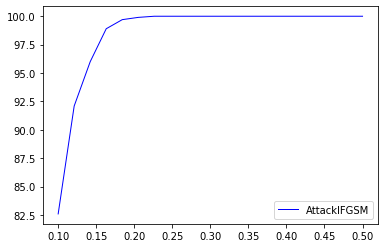

In [342]:
x1, y1 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackIFGSM, samples=1000)

Perturbations list: [0.1        0.12105263 0.14210526 0.16315789 0.18421053 0.20526316
 0.22631579 0.24736842 0.26842105 0.28947368 0.31052632 0.33157895
 0.35263158 0.37368421 0.39473684 0.41578947 0.43684211 0.45789474
 0.47894737 0.5       ]


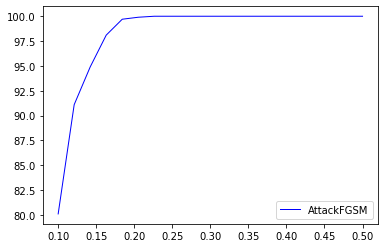

In [343]:
x2, y2 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackFGSM, samples=1000)

Perturbations list: [0.1        0.12105263 0.14210526 0.16315789 0.18421053 0.20526316
 0.22631579 0.24736842 0.26842105 0.28947368 0.31052632 0.33157895
 0.35263158 0.37368421 0.39473684 0.41578947 0.43684211 0.45789474
 0.47894737 0.5       ]


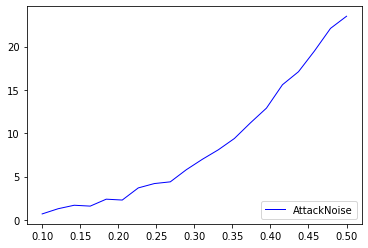

In [344]:
x3, y3 = untargeted_attack_benchmark(X_test[correct_pred_idx], y_labels, model=lg, attack_model=AttackNoise, samples=1000)

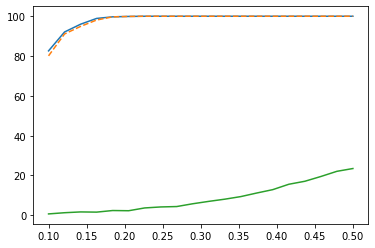

In [345]:
plt.plot(np.array(x1), y1)
plt.plot(np.array(x2), y2, '--')
plt.plot(np.array(x3), y3)

### Untargeted Noise Attack

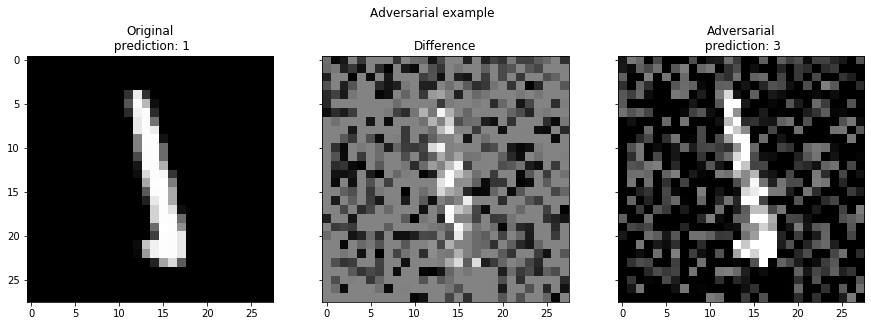

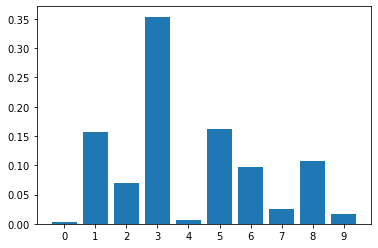

Perturbation: 0.5; Result: True
Max value: 255.0
Min value: 0.0
Max perturbation: 118.10909396524569


In [232]:
index = 38
x = np.expand_dims(X_test.iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackNoise, max_perturbation=0.5)

### Untargeted AttackFGSM

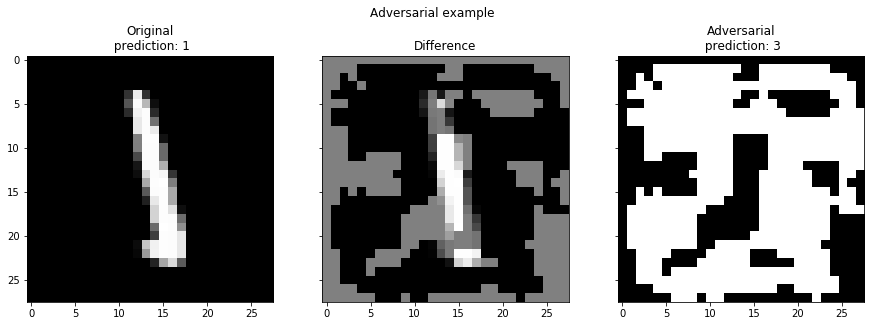

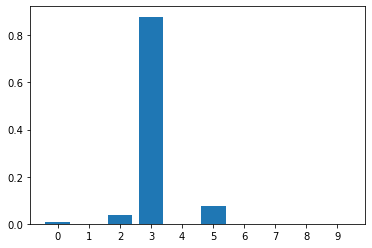

Perturbation: 1; Result: True
Max value: 255.0
Min value: 0.0
Max perturbation: 255.0


In [261]:
index = 38
x = np.expand_dims(X_test.iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackFGSM, max_perturbation=1)

### Untargeted I-FGSM

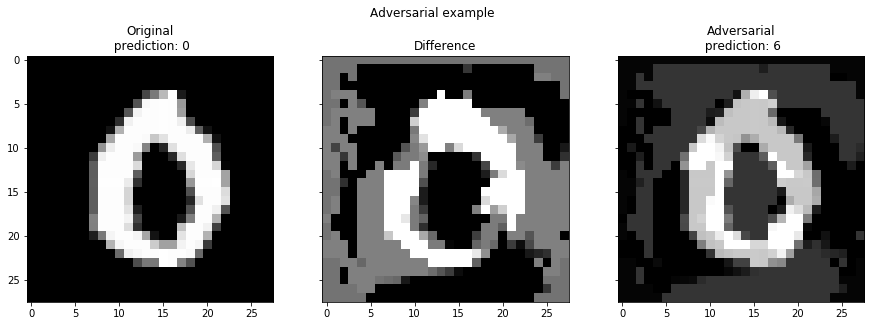

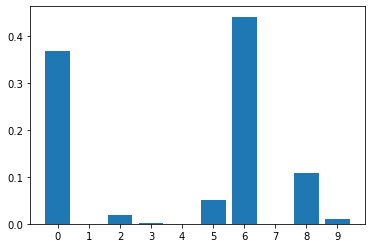

Perturbation: 0.21; Result: True
Max value: 255.0
Min value: 0.0
Max perturbation: 53.55000000000007


In [235]:
index = 0
x = np.expand_dims(X_test.iloc[index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackIFGSM, max_perturbation=1, max_iters=100)

### Targeted FGSM

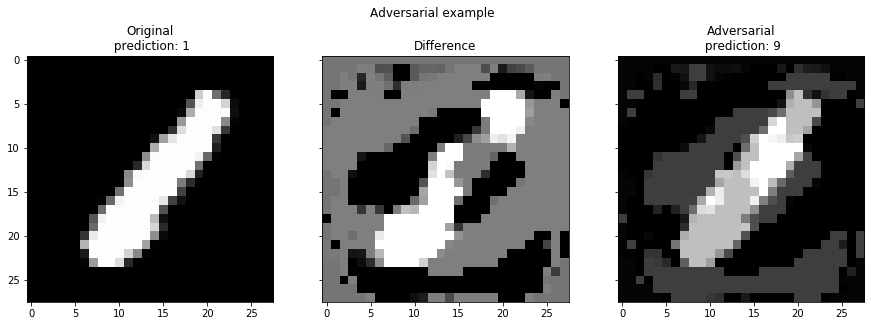

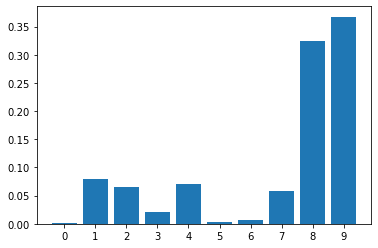

Perturbation: 0.245; Result: True
Max value: 255.0
Min value: 0.0
Max perturbation: 62.47500000000008


In [240]:
index = 1
x = np.expand_dims(X_test.iloc[index, :], axis=0)
y = np.zeros(len(y_labels))
y[9] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackTIFGSM, max_perturbation=0.5, max_iters=100)

In [284]:
y_real = np.array(y_test.iloc[:, 0])

comp = pd.DataFrame({"y_pred": y_pred, "y_real": y_real})
print(comp.head(20))

[0 1 1 ... 3 0 0]
    y_pred  y_real
0        0       0
1        1       1
2        1       1
3        4       4
4        0       0
5        8       8
6        0       0
7        9       9
8        8       8
9        0       0
10       3       3
11       6       6
12       3       3
13       6       6
14       6       6
15       3       3
16       6       6
17       1       6
18       5       5
19       8       8


In [306]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
rmse = mean_squared_error(y_real, y_pred, squared=True)
mse = mean_squared_error(y_real, y_pred, squared=False)
mae = mean_absolute_error(y_real, y_pred)
r2 = r2_score(y_real, y_pred)
accuracy = int(sum(y_real == y_pred) / len(y_pred) * 100)


#print(f'Coefficients\n {theta}')
print(f'Root mean squared error: {rmse}')
print(f'Mean squared error: {mse}')
print(f'Mean absolute error: {mae}')
print(f'Coefficient of determination: {r2}')
print(f"Accuracy: {accuracy}%")

Root mean squared error: 1.4227380952380952
Mean squared error: 1.1927858547275345
Mean absolute error: 0.30273809523809525
Coefficient of determination: 0.8293950985557347
Accuracy: 91%


In [243]:
# import numpy as np
# import matplotlib.pyplot as plt


# # Example data
# t = np.arange(0.0, 1.0 + 0.01, 0.01)
# s = np.cos(4 * np.pi * t) + 2

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# plt.plot(t, s)

# plt.xlabel(r'\textbf{time} (s)')
# plt.ylabel(r'\textit{voltage} (mV)',fontsize=16)
# plt.title(r"\TeX\ is Number "
#           r"$\displaystyle\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}$!",
#           fontsize=16, color='gray')
# # Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)

# # plt.savefig('tex_demo')
# # plt.show()